# 17) Cholesky QR

## Last time

* Householder QR

## Today

1. Recap on Householder QR
2. Composition of reflectors
3. Cholesky Decomposition
4. Profiling  



In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

In [2]:
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

function reflectors_to_dense(V)
    m = length(V[1])
    Q = diagm(ones(m))
    for j in 1:m
        Q[:,j] = reflectors_mult(V, Q[:,j])
    end
    Q
end

reflectors_to_dense (generic function with 1 method)

![Choosing the better of two Householder reflectors (Trefethen and Bau, 1999).](../img/TB-Householder2reflectors.png)

## 1. Recap on Householder QR

### Householder: An improved algorithm



In [3]:
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <--- here we pick the sign of v so that moves it the largest distance
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

In [4]:
A = [1 0; 0 1]
V, R = qr_householder(A)
tau = [2*v[1]^2 for v in V]
@show tau
V1 = [v ./ v[1] for v in V]
@show V1
R

tau = [2.0, 2.0]
V1 = [[1.0, 0.0], [1.0]]


2×2 Matrix{Int64}:
 -1   0
  0  -1

### Householder is backward stable

In [5]:
m = 40
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 5.949301496893686e-15
norm(Q * R - A) = 1.2090264267288813e-14


In [6]:
A = [1 0; 0 1.]
V, R = qr_householder(A)  # we don't get NaNs anymore
qr(A) # Julia built-in

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor: 2×2 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}
R factor:
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

### Orthogonality is preserved

norm(Q' * Q - I) = 1.4985231287367549
norm(v) = 1.4245900685395503


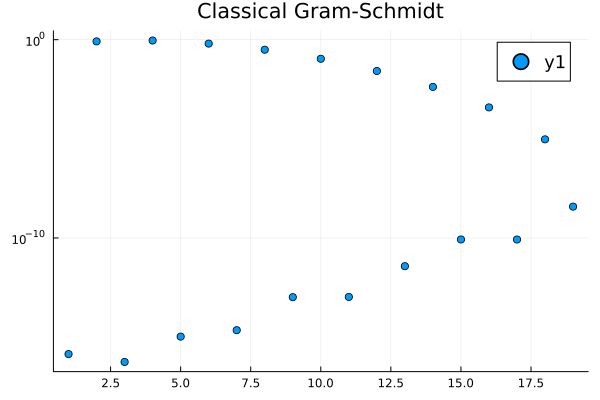

In [7]:
x = LinRange(-1, 1, 20)
A = vander(x) # [1 | x | x^2 | ... x^19]
Q, _ = gram_schmidt_classical(A)
@show norm(Q' * Q - I)
v = A[:,end]
@show norm(v)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Classical Gram-Schmidt")

norm(Q' * Q - I) = 3.840520021608235e-15


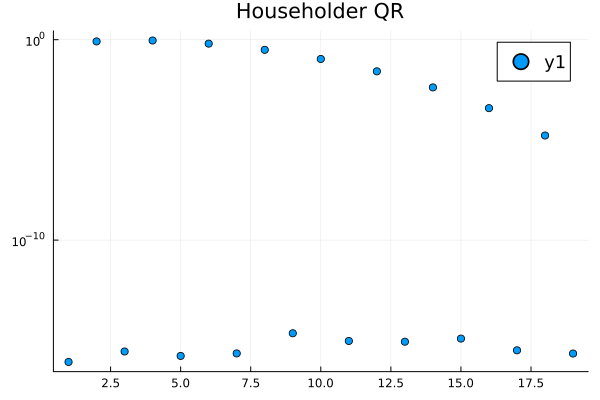

In [8]:
Q = reflectors_to_dense(qr_householder(A)[1])
@show norm(Q' * Q - I)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Householder QR") # they are less linearly dependent, i.e., more linearly independent

### Summary: 
- Classic Gram-Schmidt: Usually very poor orthogonality.
- Modified Gram-Schmidt: Depends upon condition of $A$. Fails completely when $A$ is singular.
- Householder triangularization: Always good orthogonality and backward stable.

## 2. Composition of reflectors

\begin{align}
(I - 2 v v^T) (I - 2 w w^T) &= I - 2 v v^T - 2 w w^T + 4 v (v^T w) w^T \\
&= I - \Bigg[v \Bigg| w \Bigg] \begin{bmatrix} 2 & -4 v^T w \\ 0 & 2 \end{bmatrix} \begin{bmatrix} v^T \\ w^T \end{bmatrix}
\end{align}

This turns applying reflectors from a sequence of vector operations to a sequence of (smallish) matrix operations. It's the key to high performance and the native format (`QRCompactWY`) returned by Julia `qr()`.

In [9]:
Q, R = qr(A) # Julia built-in

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor: 20×20 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}
R factor:
20×20 Matrix{Float64}:
 -4.47214  0.0      -1.64763       0.0          …  -0.514468      2.22045e-16
  0.0      2.71448   1.11022e-16   1.79412         -2.498e-16     0.823354
  0.0      0.0      -1.46813       5.55112e-17     -0.944961     -2.23779e-16
  0.0      0.0       0.0          -0.774796         3.83808e-17  -0.913056
  0.0      0.0       0.0           0.0              0.797217     -4.06264e-16
  0.0      0.0       0.0           0.0          …  -3.59496e-16   0.637796
  0.0      0.0       0.0           0.0             -0.455484     -1.3936e-15
  0.0      0.0       0.0           0.0              4.40958e-16  -0.313652
  0.0      0.0       0.0           0.0             -0.183132      1.64685e-15
  0.0      0.0       0.0           0.0              4.82253e-16   0.109523
  0.0      0.0       0.0           0.0          

### This works even for very nonsquare matrices

In [10]:
A = rand(1000000, 5)
Q, R = qr(A)
@show size(Q)
@show norm(Q*R - A)
R

size(Q) = (1000000, 1000000)
norm(Q * R - A) = 2.465762200045769e-12


5×5 Matrix{Float64}:
 -577.496  -433.091  -432.904  -432.963  -432.737
    0.0     381.743   163.896   163.632   163.202
    0.0       0.0    -345.445  -102.959  -103.506
    0.0       0.0       0.0    -329.062   -75.0942
    0.0       0.0       0.0       0.0    -320.445

This is known as a "full" (or "complete") QR factorization, in contrast to a reduced QR factorization in which $Q$ has the same shape as $A$.
* How much memory does $Q$ use?

### Compare to Python's [`numpy.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)

* Need to decide up-front whether you want full or reduced QR.
* Full QR is expensive to represent.

## 3. Cholesky decomposition

First some definitions:

A matrix $A \in \R^{n \times n}$ is _symmetric_ if $A = A^{T}$ and _positive definite_ if $x^{T}Ax > 0$ for all nonzero $x \in \R^n$. Symmetric _and_ positive definite matrices, i.e., _symmetric positive definite (SPD)_ matrices, are the most important class of specially structured matrices that arise in applications.

Intuitively, the largest entry in an SPD matrix is on the diagonal and, more qualitatively, SPD matrices have more "mass" on the diagonal than off the diagonal.

If $A$ can be factored in a QR-factorization, i.e., $A = QR$, then we can write:

$$(QR)^T QR = A^T A$$

By applying the transpose of a product, we get:


$$R^T Q^T  QR = A^T A$$

And since Q is orthogonal (remember: $QQ^T = Q^TQ =I$), we get:

$$R^T( Q^T  Q)R = A^T A$$
$$R^T R = A^T A$$

If, A is SPD, then it is possible to find a _lower triangular_ matrix $L$ such that:

$$L L^T = A^T A$$

Then, we have that $$R^{T}R = L L^{T}$$

Hence, the lower triangular matrix $L$ is such that $L = R^T$ and can be identified as the Cholesky factor of $A^TA$.

It follows (you can prove it yourself for exercise) that $Q = A L^{-T}$.

In [11]:
function qr_chol(A)
    R = cholesky(A' * A).U # using cholesky function from the LinearAlgebra.jl package. The decomposition produces the components L and U.
    Q = A / R
    Q, R
end

A = rand(10,4) # use a random rectangular matrix
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 9.497292348511781e-16
norm(Q * R - A) = 2.37549462997806e-16


2.37549462997806e-16

In [12]:
x = LinRange(-1, 1, 15)
A = vander(x) # use the Vadermonde matrix
Q, R = qr_chol(A)
@show norm(Q' * Q - I) # really not orthogonal
@show norm(Q * R - A);

norm(Q' * Q - I) = 4.3924133095508784e-5
norm(Q * R - A) = 7.092119431498881e-16


### Can we fix this?

Note that the product of two triangular matrices is triangular.

In [13]:
R = triu(rand(5,5))
R * R

5×5 Matrix{Float64}:
 0.81932  0.77297   0.383566   0.481441  1.19
 0.0      0.636025  0.90238    1.15553   0.869707
 0.0      0.0       0.0750742  0.312202  0.579002
 0.0      0.0       0.0        0.247336  0.290351
 0.0      0.0       0.0        0.0       0.708143

In [14]:
function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

x = LinRange(-1, 1, 15)
A = vander(x) # use the Vadermonde matrix
Q, R = qr_chol2(A)
@show norm(Q' * Q - I) # orthogonal to machine precision now!
@show norm(Q * R - A);

norm(Q' * Q - I) = 9.892569635797733e-16
norm(Q * R - A) = 7.622613303296868e-16


### How fast are these methods?

Let's do some timing with Julia's macro [`@time`](https://docs.julialang.org/en/v1/manual/performance-tips/#Measure-performance-with-[@time](@ref)-and-pay-attention-to-memory-allocation).

In [15]:
m, n = 5000, 2000
A = randn(m, n)

@time qr(A); # Julia's built-in

  0.847167 seconds (7 allocations: 77.393 MiB, 0.48% gc time)


In [16]:
A = randn(m, n)
@time qr_chol(A);

  1.016496 seconds (8 allocations: 137.329 MiB, 18.48% gc time)


## 4. Profiling

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


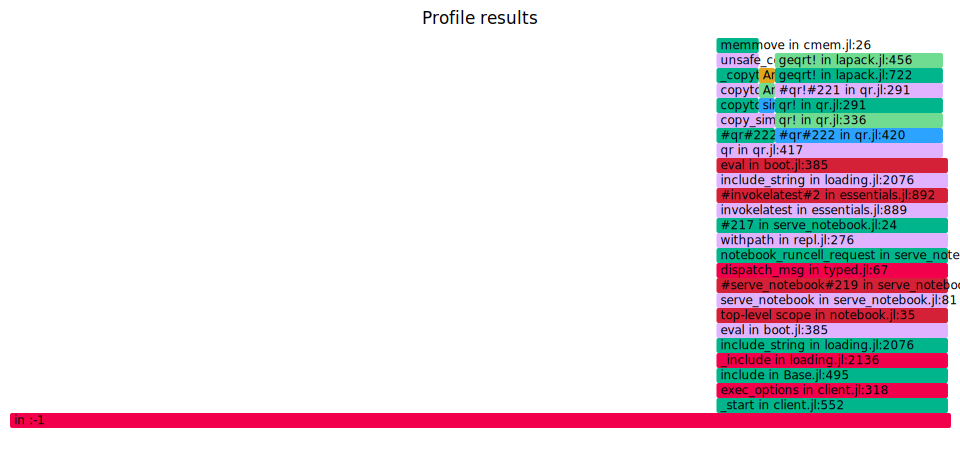

In [17]:
using Pkg
Pkg.add("ProfileSVG")

using ProfileSVG

ProfileSVG.@profview qr(A)